In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import itertools
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
df_train = pd.read_csv('main_train.csv')
df_test = pd.read_csv('main_test.csv')

In [3]:
df_train['hero'] = df_train['hero'].replace(np.nan, 'nan', regex=True)
df_test['hero'] = df_test['hero'].replace(np.nan, 'nan', regex=True)

In [ ]:
plt.scatter(np.arange(len(df_train['win'])), df_train['win'])

In [4]:
df_train['win'] = 0

In [5]:
df_train.columns

Index(['match_id', 'radiant', 'hero', 'gold_0', 'lh_0', 'xp_0', 'gold_60',
       'lh_60', 'xp_60', 'gold_120', 'lh_120', 'xp_120', 'gold_180', 'lh_180',
       'xp_180', 'gold_240', 'lh_240', 'xp_240', 'gold_300', 'lh_300',
       'xp_300', 'gold_360', 'lh_360', 'xp_360', 'gold_420', 'lh_420',
       'xp_420', 'gold_480', 'lh_480', 'xp_480', 'gold_540', 'lh_540',
       'xp_540', 'gold_600', 'lh_600', 'xp_600', 'level_180', 'level_240',
       'level_300', 'level_360', 'level_420', 'level_480', 'level_540',
       'level_600', 'radiant_win', 'win'],
      dtype='object')

In [4]:
df_train['win'] = 1 - (df_train['radiant'] - df_train['radiant_win'])**2

# Gold

Оставляем только золото к 600 секунде, и сортируем от самого маленького количества в команде, до самого большого. Аналогично с xp и lh. Создаем столбцы для этих значений

In [7]:
def new_features(df, feature):
    team_feat = df[feature].values.reshape(-1, 5)
    team_feat.sort(axis = 1)
    return team_feat

In [8]:
gold_600_train = new_features(df_train, 'gold_600')
lh_600_train = new_features(df_train, 'lh_600')
xp_600_train = new_features(df_train, 'xp_600')

In [9]:
gold_radiant = pd.DataFrame(gold_600_train[0::2], columns = ["Radiant_gold_%d" % (i + 1) for i in range(5)])
lh_radiant = pd.DataFrame(lh_600_train[0::2], columns = ["Radiant_lh_%d" % (i + 1) for i in range(5)])
xp_radiant = pd.DataFrame(xp_600_train[0::2], columns = ["Radiant_xp_%d" % (i + 1) for i in range(5)])

In [10]:
gold_Dare = pd.DataFrame(gold_600_train[1::2], columns = ["Dare_gold_%d" % (i + 1) for i in range(5)])
lh_Dare = pd.DataFrame(lh_600_train[1::2], columns = ["Dare_lh_%d" % (i + 1) for i in range(5)])
xp_Dare = pd.DataFrame(xp_600_train[1::2], columns = ["Dare_xp_%d" % (i + 1) for i in range(5)])

In [11]:
gold_radiant_all = pd.DataFrame(gold_600_train, columns = ["gold_%d" % (i + 1) for i in range(5)])
lh_radiant_all = pd.DataFrame(lh_600_train, columns = ["lh_%d" % (i + 1) for i in range(5)])
xp_radiant_all = pd.DataFrame(xp_600_train, columns = ["xp_%d" % (i + 1) for i in range(5)])
gold_all = pd.concat([gold_radiant_all, lh_radiant_all, xp_radiant_all], axis = 1)

In [12]:
gold_train = pd.concat([gold_radiant, lh_radiant, xp_radiant, gold_Dare, lh_Dare, xp_Dare], axis = 1)

# Gold test

In [13]:
gold_600_test = new_features(df_test, 'gold_600')
lh_600_test = new_features(df_test, 'lh_600')
xp_600_test = new_features(df_test, 'xp_600')

In [14]:
gold_radiant_test = pd.DataFrame(gold_600_test[0::2], columns = ["Radiant_gold_%d" % (i + 1) for i in range(5)])
lh_radiant_test = pd.DataFrame(lh_600_test[0::2], columns = ["Radiant_lh_%d" % (i + 1) for i in range(5)])
xp_radiant_test = pd.DataFrame(xp_600_test[0::2], columns = ["Radiant_xp_%d" % (i + 1) for i in range(5)])

In [15]:
gold_Dare_test = pd.DataFrame(gold_600_test[1::2], columns = ["Dare_gold_%d" % (i + 1) for i in range(5)])
lh_Dare_test = pd.DataFrame(lh_600_test[1::2], columns = ["Dare_lh_%d" % (i + 1) for i in range(5)])
xp_Dare_test = pd.DataFrame(xp_600_test[1::2], columns = ["Dare_xp_%d" % (i + 1) for i in range(5)])

In [16]:
gold_test = pd.concat([gold_radiant_test, lh_radiant_test, xp_radiant_test, gold_Dare_test, lh_Dare_test, xp_Dare_test], axis = 1)

In [17]:
gold_radiant_all_test = pd.DataFrame(gold_600_test, columns = ["gold_%d" % (i + 1) for i in range(5)])
lh_radiant_all_test = pd.DataFrame(lh_600_test, columns = ["lh_%d" % (i + 1) for i in range(5)])
xp_radiant_all_test = pd.DataFrame(xp_600_test, columns = ["xp_%d" % (i + 1) for i in range(5)])
gold_all_test = pd.concat([gold_radiant_all_test, lh_radiant_all_test, xp_radiant_all_test], axis = 1)

# win rate of pairs

Посчитаем винрейты пар в команде, потом добавим как признак их суммму. Сначала предполагалось добавить как класс: высокие значения победы и низкие. С помощью метода проб и ошибок решил оставить просто сумму винрейтов. Так же пары, которые редко встречаются, принимают значение 0,5.

In [18]:
teams = df_train['hero'].values
teams = teams.reshape(-1, 5)

heroes = df_train['hero'].unique()
heroes_pairs = list(itertools.combinations(heroes, 2))
team_pairs = []
for i in range(len(teams)):
    team_pairs.append(list(itertools.combinations(set(teams[i]), 2)))

In [19]:
wins = df_train['win'][::5]

In [20]:
win = []
for i in wins:
    win.append([i]*10)

In [21]:
print(np.array(win, dtype = 'int').shape,
     np.array(team_pairs).shape)

(79918, 10) (79918, 10, 2)


In [22]:
win = np.array(win, dtype = 'int').ravel()
team_pairs_for_df = []
for j in team_pairs:
    team_pairs_for_df.append([str(sorted(i)) for i in j])
team_pairs_for_df = np.array(team_pairs_for_df).ravel()

In [23]:
df_pairs = pd.DataFrame({'pair': team_pairs_for_df,
     'win':win})

In [24]:
df_pairs.head()

,pair,win
0,"['Riki', 'Tusk']",1
1,"['Rubick', 'Tusk']",1
2,"['Templar Assassin', 'Tusk']",1
3,"['Tusk', 'Wraith King']",1
4,"['Riki', 'Rubick']",1


In [25]:
df_pairs['count'] = df_pairs.groupby(['pair'])['win'].transform('count')
df_pairs['win_number'] = df_pairs['win'].groupby(df_pairs['pair']).transform('sum')
df_pairs['win_rate'] = df_pairs['win_number']/df_pairs['count']

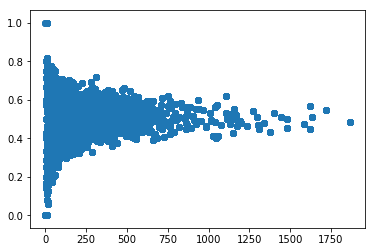

In [26]:
plt.scatter(df_pairs['count'], df_pairs['win_rate'])

In [27]:
df_pairs['win_rate'][df_pairs['count'] < 500] = 0.5

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


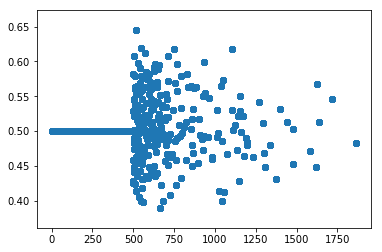

In [28]:
plt.scatter(df_pairs['count'], df_pairs['win_rate'])

In [29]:
#p25 = np.percentile(df_pairs[df_pairs['count'] >= 500]['win_rate'], 25)
#p75 = np.percentile(df_pairs[df_pairs['count'] >= 500]['win_rate'], 75)

In [30]:
#df_pairs['high_win_rate'] = 0
#df_pairs['high_win_rate'][df_pairs['win_rate'] > p75] = 1

In [31]:
#df_pairs['low_win_rate'] = 0
#df_pairs['low_win_rate'][df_pairs['win_rate'] < p25] = 1

In [32]:
win_rate = np.array(df_pairs['win_rate'], dtype = 'float64').reshape(-1, 10)
win_rate = [win_rate[i].sum() for i in range(len(win_rate))]

In [33]:
#high = np.array(df_pairs['high_win_rate'], dtype = 'float64').reshape(-1, 10)
#high = [high[i].sum() for i in range(len(high))]

In [34]:
radiant_win_rates = pd.DataFrame({'radiant_win': win_rate[0::2]})
dare_win_rates = pd.DataFrame({'dare_win': win_rate[1::2]})

In [35]:
df_win_all = pd.DataFrame({'win': win_rate})

In [36]:
df_win_rates = pd.concat([radiant_win_rates, dare_win_rates], axis = 1)

# Test win rate 

Ставятся значения из трэйн выборки. 

In [37]:
teams_test = df_test['hero'].values
teams_test = teams_test.reshape(-1, 5)

team_pairs_test = []
for i in range(len(teams_test)):
    team_pairs_test.append(list(set(itertools.combinations(teams_test[i], 2))))

In [38]:
team_pairs_for_test = []
for j in team_pairs_test:
    team_pairs_for_test.append([str(sorted(i)) for i in j])
team_pairs_for_test = np.array(team_pairs_for_test).ravel()

In [39]:
#test_unique = unique(team_pairs_for_test)
mean_high_win = df_pairs.groupby('pair')['win_rate'].mean()

test_high = []
for i in team_pairs_for_test:
    if i in mean_high_win:
        test_high.append(mean_high_win[i])
    else:
        test_high.append(0)

In [40]:
df_pairs_test = pd.DataFrame({'pair': team_pairs_for_test, 'win': np.array(test_high, dtype = 'float64')})

In [41]:
#low_test = np.array(df_pairs_test['low_win'], dtype = 'int').reshape(-1, 10)
#low_test = [low_test[i].sum() for i in range(len(low_test))]

In [42]:
high_test = np.array(df_pairs_test['win'], dtype = 'float64').reshape(-1, 10)
high_test = [high_test[i].sum() for i in range(len(high_test))]

In [43]:
radiant_win_rates_test = pd.DataFrame({'radiant_high_win': high_test[0::2]})
dare_win_rates_test = pd.DataFrame({'dare_high_win': high_test[1::2]})

In [44]:
df_win_rate_test= pd.DataFrame({'radiant_high_win': high_test[0::2],
     'dare_high_win': high_test[1::2]})

In [45]:
df_win_test_all = pd.DataFrame({'win': high_test})

# Counter

Для команды радиант считается, контр вин рейты. Считаем, сколько раз герои выигрывали героев из противоположной команды. Шаги аналогичны обычным вин рейтам.

In [46]:
teams

array([['Rubick', 'Wraith King', 'Riki', 'Tusk', 'Templar Assassin'],
       ['Bounty Hunter', 'Invoker', 'Earthshaker', 'Anti-Mage',
        'Shadow Fiend'],
       ['Zeus', 'Slark', 'Mirana', 'Phantom Assassin', 'Ancient Apparition'],
       ..., 
       ['Mirana', 'Templar Assassin', 'Earthshaker', 'Dark Seer', 'Rubick'],
       ['Crystal Maiden', 'Razor', 'Silencer', 'Phantom Assassin',
        'Earthshaker'],
       ['Tusk', 'Anti-Mage', 'Phantom Lancer', "Nature's Prophet",
        'Techies']], dtype=object)

In [47]:
war_pairs = []
for i in range(0, len(teams), 2):
    war_pairs.append(list(itertools.product(teams[i], teams[i+1])))

In [48]:
war_pairs_for_df_sorted = []
war_pairs_for_df = []
reverse_war_pairs = []
for j in war_pairs:
    war_pairs_for_df_sorted.append([str(sorted(i)) for i in j])
    war_pairs_for_df.append([str(list(i)) for i in j])
war_pairs_for_df_sorted = np.array(war_pairs_for_df_sorted).ravel()
war_pairs_for_df = np.array(war_pairs_for_df).ravel()

In [49]:
win = df_train['win'][5::10]

In [50]:
win_for_df = []
for i in win:
    win_for_df.append([i]*25)
win_for_df = np.array(win_for_df, dtype = 'int').ravel()

In [51]:
df_war_pairs = pd.DataFrame({'war_pair': war_pairs_for_df, 'war_pair_sorted': war_pairs_for_df_sorted,
     'win':win_for_df})

In [52]:
df_war_pairs['count'] = df_war_pairs.groupby(['war_pair'])['win'].transform('count')
df_war_pairs['win_number'] = df_war_pairs['win'].groupby(df_war_pairs['war_pair']).transform('sum')
df_war_pairs['win_rate'] = df_war_pairs['win_number']/df_war_pairs['count']

In [53]:
df_war_pairs['count_sorted'] = df_war_pairs.groupby(['war_pair_sorted'])['win'].transform('count')
df_war_pairs['win_number_sorted'] = df_war_pairs['win'].groupby(df_war_pairs['war_pair_sorted']).transform('sum')

In [54]:
df_war_pairs['count_reverse'] = df_war_pairs['count_sorted'] - df_war_pairs['count']
df_war_pairs['sum_win_rates'] = df_war_pairs.groupby(['war_pair_sorted'])['win_rate'].transform('sum')
df_war_pairs['reverse_win_rates'] = (df_war_pairs['sum_win_rates']\
                                         - df_war_pairs['count']*df_war_pairs['win_rate'])/df_war_pairs['count_reverse']

In [55]:
df_war_pairs['counter_win_rate'] = (df_war_pairs['count']*(1 - df_war_pairs['win_rate']) + \
                                    df_war_pairs['count_reverse']*(df_war_pairs['reverse_win_rates']))/(df_war_pairs['count'] + \
                                                                                                 df_war_pairs['count_reverse'])

In [56]:
df_war_pairs['counter_win_rate'][df_war_pairs['count_sorted'] < 1000] = 0.5

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


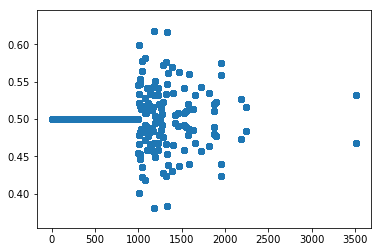

In [57]:
plt.scatter(df_war_pairs['count_sorted'], df_war_pairs['counter_win_rate'])

In [58]:
df_war_pairs[df_war_pairs['war_pair_sorted'] == str(['Rubick', 'Shadow Fiend'])]

,war_pair,war_pair_sorted,win,count,win_number,win_rate,count_sorted,win_number_sorted,count_reverse,sum_win_rates,reverse_win_rates,counter_win_rate
4,"['Rubick', 'Shadow Fiend']","['Rubick', 'Shadow Fiend']",0,579,307,0.530225,1189,569,610,569.0,0.429508,0.449117
521,"['Rubick', 'Shadow Fiend']","['Rubick', 'Shadow Fiend']",0,579,307,0.530225,1189,569,610,569.0,0.429508,0.449117
962,"['Shadow Fiend', 'Rubick']","['Rubick', 'Shadow Fiend']",0,610,262,0.429508,1189,569,579,569.0,0.530225,0.550883
4221,"['Rubick', 'Shadow Fiend']","['Rubick', 'Shadow Fiend']",1,579,307,0.530225,1189,569,610,569.0,0.429508,0.449117
4466,"['Rubick', 'Shadow Fiend']","['Rubick', 'Shadow Fiend']",0,579,307,0.530225,1189,569,610,569.0,0.429508,0.449117
6027,"['Rubick', 'Shadow Fiend']","['Rubick', 'Shadow Fiend']",1,579,307,0.530225,1189,569,610,569.0,0.429508,0.449117
6265,"['Rubick', 'Shadow Fiend']","['Rubick', 'Shadow Fiend']",1,579,307,0.530225,1189,569,610,569.0,0.429508,0.449117
7898,"['Shadow Fiend', 'Rubick']","['Rubick', 'Shadow Fiend']",0,610,262,0.429508,1189,569,579,569.0,0.530225,0.550883
9132,"['Rubick', 'Shadow Fiend']","['Rubick', 'Shadow Fiend']",1,579,307,0.530225,1189,569,610,569.0,0.429508,0.449117
9310,"['Shadow Fiend', 'Rubick']","['Rubick', 'Shadow Fiend']",1,610,262,0.429508,1189,569,579,569.0,0.530225,0.550883


In [59]:
counter_win = np.array(df_war_pairs['counter_win_rate'], dtype = 'float64').reshape(-1, 25)
counter_win = [counter_win[i].sum() for i in range(len(counter_win))]
counter_win = pd.DataFrame({'counter_win': counter_win})

# Counter Test

Аналогично берем из трейна.

In [60]:
war_pairs_test = []
for i in range(0, len(teams_test), 2):
    war_pairs_test.append(list(itertools.product(teams_test[i], teams_test[i+1])))

In [61]:
war_pairs_for_test = []
for j in war_pairs_test:
    war_pairs_for_test.append([str(list(i)) for i in j])
war_pairs_for_test = np.array(war_pairs_for_test).ravel()

In [62]:
test_unique = unique(war_pairs_for_df)
mean_counter = df_war_pairs.groupby('war_pair')['counter_win_rate'].mean()

test_counter_rate = []
for i in war_pairs_for_test:
    if i in mean_counter:
        test_counter_rate.append(mean_counter[i])
    else:
        test_counter_rate.append(0.5)

In [63]:
df_war_test = pd.DataFrame({'war_pair': war_pairs_for_test,
     'counter_win_rate':test_counter_rate})

In [64]:
counter_win_test = np.array(df_war_test['counter_win_rate'], dtype = 'float64').reshape(-1, 25)
counter_win_test = [counter_win_test[i].sum() for i in range(len(counter_win_test))]
counter_win_test = pd.DataFrame({'counter_win': counter_win_test})

# Heroes

In [65]:
heroes_dummies = pd.get_dummies(df_train['hero']).values

In [66]:
heroes_dummies = np.array(heroes_dummies, dtype = 'int')

In [67]:
radiant_team_heroes = + heroes_dummies[0::10] + heroes_dummies[1::10] +  heroes_dummies[2::10] +  heroes_dummies[3::10] +  heroes_dummies[4::10]
dare_team_heroes = - heroes_dummies[5::10] - heroes_dummies[6::10] - heroes_dummies[7::10] - heroes_dummies[8::10] - heroes_dummies[9::10]
final_dummies = pd.DataFrame(radiant_team_heroes + dare_team_heroes)

# Heroes test

Создаем дамми для героев. Они принимают 1 для радианта, -1 для противоположной команды. Герои в командах уникальны.

In [68]:
heroes_dummies = pd.get_dummies(df_test['hero']).values

In [69]:
heroes_dummies = np.array(heroes_dummies, dtype = 'int')

In [70]:
radiant_team_heroes = + heroes_dummies[0::10] + heroes_dummies[1::10] +  heroes_dummies[2::10] +  heroes_dummies[3::10] +  heroes_dummies[4::10]
dare_team_heroes = - heroes_dummies[5::10] - heroes_dummies[6::10] - heroes_dummies[7::10] - heroes_dummies[8::10] - heroes_dummies[9::10]
final_dummies_test = pd.DataFrame(radiant_team_heroes + dare_team_heroes)

# final dfs

In [71]:
prefinal_train = pd.concat([gold_train, df_win_rates,  counter_win], axis = 1)

In [72]:
prefinal_test = pd.concat([gold_test, df_win_rate_test, counter_win_test], axis = 1)

In [73]:
prefinal_test.columns

Index(['Radiant_gold_1', 'Radiant_gold_2', 'Radiant_gold_3', 'Radiant_gold_4',
       'Radiant_gold_5', 'Radiant_lh_1', 'Radiant_lh_2', 'Radiant_lh_3',
       'Radiant_lh_4', 'Radiant_lh_5', 'Radiant_xp_1', 'Radiant_xp_2',
       'Radiant_xp_3', 'Radiant_xp_4', 'Radiant_xp_5', 'Dare_gold_1',
       'Dare_gold_2', 'Dare_gold_3', 'Dare_gold_4', 'Dare_gold_5', 'Dare_lh_1',
       'Dare_lh_2', 'Dare_lh_3', 'Dare_lh_4', 'Dare_lh_5', 'Dare_xp_1',
       'Dare_xp_2', 'Dare_xp_3', 'Dare_xp_4', 'Dare_xp_5', 'dare_high_win',
       'radiant_high_win', 'counter_win'],
      dtype='object')

In [74]:
prefinal_train

,Radiant_gold_1,Radiant_gold_2,Radiant_gold_3,Radiant_gold_4,Radiant_gold_5,Radiant_lh_1,Radiant_lh_2,Radiant_lh_3,Radiant_lh_4,Radiant_lh_5,...,Dare_lh_4,Dare_lh_5,Dare_xp_1,Dare_xp_2,Dare_xp_3,Dare_xp_4,Dare_xp_5,radiant_win,dare_win,counter_win
0,1569.0,2072.0,2489.0,3367.0,3726.0,2.0,3.0,36.0,49.0,58.0,...,38.0,58.0,1644.0,1804.0,2653.0,2965.0,3011.0,5.153882,4.859362,12.593903
1,2108.0,2349.0,3002.0,3070.0,3399.0,8.0,12.0,29.0,38.0,45.0,...,25.0,49.0,1800.0,1882.0,2569.0,2956.0,4888.0,5.000000,5.000000,12.500000
2,1444.0,2276.0,3089.0,3965.0,4249.0,2.0,13.0,14.0,32.0,63.0,...,24.0,25.0,1635.0,1864.0,2103.0,2497.0,4214.0,4.898028,5.000000,12.500000
3,1892.0,2088.0,2608.0,3076.0,4027.0,8.0,9.0,28.0,32.0,43.0,...,35.0,48.0,1759.0,2684.0,2995.0,3261.0,3541.0,5.010390,4.756103,12.558400
4,1160.0,1986.0,2497.0,2688.0,3206.0,0.0,15.0,36.0,39.0,44.0,...,41.0,50.0,1472.0,1968.0,2329.0,2341.0,4087.0,4.954139,5.017660,12.495154
5,1389.0,2081.0,2132.0,3624.0,5461.0,1.0,16.0,22.0,31.0,62.0,...,41.0,55.0,1438.0,1956.0,2437.0,3255.0,4007.0,5.233567,4.898249,12.605083
6,1418.0,1661.0,2428.0,2996.0,4150.0,4.0,12.0,23.0,35.0,62.0,...,40.0,50.0,984.0,2079.0,2217.0,2530.0,3735.0,5.185184,4.934548,12.708450
7,1452.0,1501.0,1772.0,2837.0,3300.0,10.0,11.0,19.0,24.0,39.0,...,42.0,51.0,1640.0,2098.0,2405.0,2941.0,4212.0,5.084348,4.823616,12.599404
8,2007.0,2140.0,2392.0,2586.0,2993.0,5.0,7.0,15.0,15.0,25.0,...,18.0,21.0,1970.0,2153.0,2229.0,2329.0,3325.0,5.077617,5.000000,12.500000
9,1537.0,2160.0,2166.0,3077.0,4007.0,1.0,7.0,24.0,34.0,51.0,...,38.0,67.0,1295.0,1377.0,2521.0,3765.0,4035.0,5.087132,4.902778,12.408669


# Teams df

In [75]:
gold_win_train = pd.concat([gold_all, df_win_all], axis = 1)
gold_win_test = pd.concat([gold_all_test, df_win_test_all], axis = 1)

In [76]:
team_df = pd.concat([gold_win_train, gold_win_test])
team_df.head()

,gold_1,gold_2,gold_3,gold_4,gold_5,lh_1,lh_2,lh_3,lh_4,lh_5,xp_1,xp_2,xp_3,xp_4,xp_5,win
0,1569.0,2072.0,2489.0,3367.0,3726.0,2.0,3.0,36.0,49.0,58.0,1676.0,1741.0,2319.0,3859.0,4453.0,5.153882
1,1332.0,1386.0,2503.0,2804.0,3581.0,4.0,7.0,31.0,38.0,58.0,1644.0,1804.0,2653.0,2965.0,3011.0,4.859362
2,2108.0,2349.0,3002.0,3070.0,3399.0,8.0,12.0,29.0,38.0,45.0,2393.0,2719.0,2831.0,2994.0,3034.0,5.000000
3,1268.0,2375.0,2462.0,2770.0,3992.0,0.0,11.0,20.0,25.0,49.0,1800.0,1882.0,2569.0,2956.0,4888.0,5.000000
4,1444.0,2276.0,3089.0,3965.0,4249.0,2.0,13.0,14.0,32.0,63.0,1530.0,2395.0,2679.0,3408.0,3689.0,4.898028


# Scaling

Обычные вин рейты, gold, lh, xp шкалируем по всем данным, как в тесте, так и в трейне (объединяем обе выборки и команды), независимо от команды. Контр вин рейты шкалируем по матчам, объединяя трейн и тест. Сначала шкалировалось стандарт скэлером и максмином, потом стндарт и максабсом. В итоге остался только стандартскэлер. 

In [77]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MaxAbsScaler

In [78]:
prefinal_counter_tr = prefinal_train['counter_win']
prefinal_counter_te = prefinal_test['counter_win']
prefinal_counter = pd.concat([prefinal_counter_tr, prefinal_counter_te])

In [79]:
for_scalers = team_df.copy()
scaler = StandardScaler().fit(for_scalers)
gold_win_train =pd.DataFrame( scaler.transform(gold_win_train))
gold_win_test = pd.DataFrame(scaler.transform(gold_win_test))
for_scalers = pd.DataFrame(scaler.transform(for_scalers))

#scaler = MaxAbsScaler().fit(for_scalers)
#gold_win_train = pd.DataFrame(scaler.transform(gold_win_train))
#gold_win_test = pd.DataFrame(scaler.transform(gold_win_test))

In [80]:
scaler = StandardScaler().fit(prefinal_counter)
prefinal_counter_tr = pd.DataFrame(scaler.transform(prefinal_counter_tr))
prefinal_counter_te = pd.DataFrame(scaler.transform(prefinal_counter_te))
prefinal_counter = pd.DataFrame(scaler.transform(prefinal_counter))

#scaler = MaxAbsScaler().fit(prefinal_counter)
#prefinal_counter_tr = pd.DataFrame(scaler.transform(prefinal_counter_tr))
#prefinal_counter_te = pd.DataFrame(scaler.transform(prefinal_counter_te))

C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:586: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single featur

# Final

In [81]:
prefinal_train.iloc[:, :34].head()

,Radiant_gold_1,Radiant_gold_2,Radiant_gold_3,Radiant_gold_4,Radiant_gold_5,Radiant_lh_1,Radiant_lh_2,Radiant_lh_3,Radiant_lh_4,Radiant_lh_5,...,Dare_lh_4,Dare_lh_5,Dare_xp_1,Dare_xp_2,Dare_xp_3,Dare_xp_4,Dare_xp_5,radiant_win,dare_win,counter_win
0,1569.0,2072.0,2489.0,3367.0,3726.0,2.0,3.0,36.0,49.0,58.0,...,38.0,58.0,1644.0,1804.0,2653.0,2965.0,3011.0,5.153882,4.859362,12.593903
1,2108.0,2349.0,3002.0,3070.0,3399.0,8.0,12.0,29.0,38.0,45.0,...,25.0,49.0,1800.0,1882.0,2569.0,2956.0,4888.0,5.000000,5.000000,12.500000
2,1444.0,2276.0,3089.0,3965.0,4249.0,2.0,13.0,14.0,32.0,63.0,...,24.0,25.0,1635.0,1864.0,2103.0,2497.0,4214.0,4.898028,5.000000,12.500000
3,1892.0,2088.0,2608.0,3076.0,4027.0,8.0,9.0,28.0,32.0,43.0,...,35.0,48.0,1759.0,2684.0,2995.0,3261.0,3541.0,5.010390,4.756103,12.558400
4,1160.0,1986.0,2497.0,2688.0,3206.0,0.0,15.0,36.0,39.0,44.0,...,41.0,50.0,1472.0,1968.0,2329.0,2341.0,4087.0,4.954139,5.017660,12.495154


In [82]:
final_train_wd = pd.concat([gold_win_train[::2].reset_index(drop=True), gold_win_train[1::2].reset_index(drop=True),\
                         prefinal_counter_tr], axis = 1)

final_train_wd.columns = ['Radiant_gold_1', 'Radiant_gold_2', 'Radiant_gold_3', 'Radiant_gold_4',
       'Radiant_gold_5', 'Radiant_lh_1', 'Radiant_lh_2', 'Radiant_lh_3',
       'Radiant_lh_4', 'Radiant_lh_5', 'Radiant_xp_1', 'Radiant_xp_2',
       'Radiant_xp_3', 'Radiant_xp_4', 'Radiant_xp_5', 'radiant_high_win', 'Dare_gold_1',
       'Dare_gold_2', 'Dare_gold_3', 'Dare_gold_4', 'Dare_gold_5', 'Dare_lh_1',
       'Dare_lh_2', 'Dare_lh_3', 'Dare_lh_4', 'Dare_lh_5', 'Dare_xp_1',
       'Dare_xp_2', 'Dare_xp_3', 'Dare_xp_4', 'Dare_xp_5', 'dare_high_win', 'counter_win']
#final_train = pd.concat([final_train_wd, final_dummies], axis = 1)

In [83]:
final_test_wd = pd.concat([gold_win_test[::2].reset_index(drop=True), gold_win_test[1::2].reset_index(drop=True),\
                         prefinal_counter_te], axis = 1)
final_test_wd.columns = ['Radiant_gold_1', 'Radiant_gold_2', 'Radiant_gold_3', 'Radiant_gold_4',
       'Radiant_gold_5', 'Radiant_lh_1', 'Radiant_lh_2', 'Radiant_lh_3',
       'Radiant_lh_4', 'Radiant_lh_5', 'Radiant_xp_1', 'Radiant_xp_2',
       'Radiant_xp_3', 'Radiant_xp_4', 'Radiant_xp_5', 'radiant_high_win', 'Dare_gold_1',
       'Dare_gold_2', 'Dare_gold_3', 'Dare_gold_4', 'Dare_gold_5', 'Dare_lh_1',
       'Dare_lh_2', 'Dare_lh_3', 'Dare_lh_4', 'Dare_lh_5', 'Dare_xp_1',
       'Dare_xp_2', 'Dare_xp_3', 'Dare_xp_4', 'Dare_xp_5', 'dare_high_win', 'counter_win']
#final_test = pd.concat([final_test_wd, final_dummies_test], axis = 1)

In [84]:
y_train = df_train['win'][::10]
y_train.shape

(39959,)

In [85]:
final_testrain_wd = pd.concat([final_train_wd, final_test_wd])

In [86]:
final_train_wd.head()

,Radiant_gold_1,Radiant_gold_2,Radiant_gold_3,Radiant_gold_4,Radiant_gold_5,Radiant_lh_1,Radiant_lh_2,Radiant_lh_3,Radiant_lh_4,Radiant_lh_5,...,Dare_lh_3,Dare_lh_4,Dare_lh_5,Dare_xp_1,Dare_xp_2,Dare_xp_3,Dare_xp_4,Dare_xp_5,dare_high_win,counter_win
0,-0.081872,0.097784,-0.056659,0.624396,0.008995,-0.673762,-1.205948,1.487757,1.483499,0.970881,...,0.903719,0.365201,0.970881,0.002395,-0.753274,-0.041086,-0.617003,-1.764835,-1.462756,1.101365
1,1.443831,0.756885,1.058114,0.044186,-0.453841,0.925331,0.101905,0.670104,0.365201,-0.121045,...,-0.381163,-0.956424,0.214932,0.364817,-0.571438,-0.225401,-0.634627,1.317566,-0.125012,-0.015408
2,-0.435699,0.583187,1.247169,1.792632,0.749249,-0.673762,0.247222,-1.082008,-0.244780,1.390852,...,-1.198816,-1.058087,-1.800930,-0.018513,-0.613400,-1.247907,-1.533440,0.210726,-0.125012,-0.015408
3,0.832418,0.135855,0.201934,0.055907,0.435030,0.925331,-0.334046,0.553297,-0.244780,-0.289033,...,0.903719,0.060211,0.130938,0.269565,1.298213,0.709337,-0.037376,-0.894472,-2.444954,0.679135
4,-1.239595,-0.106847,-0.039275,-0.702079,-0.727013,-1.206793,0.537856,1.487757,0.466865,-0.205039,...,-1.082008,0.670191,0.298926,-0.397198,-0.370951,-0.752014,-1.838919,0.002167,0.042967,-0.073045


In [87]:
team_df = pd.concat([gold_win_train, gold_win_test])

# Further sweat

Далее добавлялись кластеры.

In [88]:
from sklearn.cluster import AgglomerativeClustering, KMeans, DBSCAN

In [89]:
cluster = KMeans(n_clusters = 3)
cluster.fit(team_df)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [90]:
team_clusters_train = pd.get_dummies(pd.DataFrame(cluster.predict(gold_win_train))[0].apply(str))

In [91]:
team_clusters_test = pd.get_dummies(pd.DataFrame(cluster.predict(gold_win_test))[0].apply(str))

In [92]:
cluster.fit(final_testrain_wd)
match_clusters_train = pd.get_dummies(pd.DataFrame(cluster.predict(final_train_wd))[0].apply(str))
match_clusters_test = pd.get_dummies(pd.DataFrame(cluster.predict(final_test_wd))[0].apply(str))

In [93]:
len(team_clusters_train['1'])

79918

In [94]:
#final_train_wd['radiant_clusters_0'] = team_clusters_train['0'][0::2].reset_index(drop=True)
final_train_wd['radiant_clusters_1'] = team_clusters_train['1'][0::2].reset_index(drop=True)
final_train_wd['radiant_clusters_2'] = team_clusters_train['2'][0::2].reset_index(drop=True)
#final_train_wd['dare_clusters_0'] = team_clusters_train['0'][1::2].reset_index(drop=True)
final_train_wd['dare_clusters_1'] = team_clusters_train['1'][1::2].reset_index(drop=True)
final_train_wd['dare_clusters_2'] = team_clusters_train['2'][1::2].reset_index(drop=True)
#final_train_wd['clusters_0'] = match_clusters_train['0'].reset_index(drop=True)
final_train_wd['clusters_1'] = match_clusters_train['1'].reset_index(drop=True)
final_train_wd['clusters_2'] = match_clusters_train['2'].reset_index(drop=True)

In [95]:
#final_test_wd['radiant_clusters_0'] = team_clusters_test['0'][0::2].reset_index(drop=True)
final_test_wd['radiant_clusters_1'] = team_clusters_test['1'][0::2].reset_index(drop=True)
final_test_wd['radiant_clusters_2'] = team_clusters_test['2'][0::2].reset_index(drop=True)
#final_test_wd['dare_clusters_0'] = team_clusters_test['0'][1::2].reset_index(drop=True)
final_test_wd['dare_clusters_1'] = team_clusters_test['1'][1::2].reset_index(drop=True)
final_test_wd['dare_clusters_2'] = team_clusters_test['2'][1::2].reset_index(drop=True)
#final_test_wd['clusters_0'] = match_clusters_test['0'].reset_index(drop=True)
final_test_wd['clusters_1'] = match_clusters_test['1'].reset_index(drop=True)
final_test_wd['clusters_2'] = match_clusters_test['2'].reset_index(drop=True)

In [96]:
final_train = pd.concat([final_train_wd, final_dummies], axis = 1)
final_test = pd.concat([final_test_wd, final_dummies_test], axis = 1)

In [97]:
final_test

,Radiant_gold_1,Radiant_gold_2,Radiant_gold_3,Radiant_gold_4,Radiant_gold_5,Radiant_lh_1,Radiant_lh_2,Radiant_lh_3,Radiant_lh_4,Radiant_lh_5,...,101,102,103,104,105,106,107,108,109,110
0,0.300261,-0.009290,-0.071870,0.305964,-0.714274,-0.140731,-0.915314,0.319682,-0.143116,-0.792999,...,0,0,0,0,-1,0,0,-1,0,0
1,-0.574400,1.446918,2.259809,2.786999,2.234003,-0.673762,-0.334046,1.604564,0.771855,1.222863,...,0,0,0,0,0,0,0,0,0,0
2,-0.871614,-0.775465,-1.438717,0.595093,1.251716,1.458362,0.683173,-0.731586,1.178509,0.382921,...,0,0,0,0,0,0,0,0,0,0
3,-1.692494,-2.010388,-1.141009,-0.614168,-0.326455,-1.206793,-1.205948,0.086067,0.365201,0.550909,...,1,0,0,0,-1,0,0,0,0,0
4,-0.178113,-0.409034,1.809989,0.597046,-0.340609,-0.673762,-0.334046,1.020527,0.060211,0.466915,...,0,0,0,0,0,0,0,0,0,0
5,-0.104517,1.101902,-0.006679,0.126236,-0.598211,1.191847,0.537856,1.721372,0.873518,-0.037051,...,0,0,0,0,1,0,0,0,0,0
6,1.140955,0.380936,-0.091428,-0.426625,-1.158710,1.991393,1.409758,0.670104,-0.143116,-1.044982,...,0,0,0,0,-1,0,0,-1,0,0
7,0.254972,-0.344789,-1.056261,-0.420764,-0.513287,-1.206793,-1.205948,-0.731586,-0.448106,-0.205039,...,0,0,0,0,0,0,0,0,0,0
8,-1.120709,-0.639838,0.603947,-0.371925,-1.114832,-1.206793,-1.060631,1.487757,0.670191,-0.205039,...,0,0,0,0,-1,1,0,0,0,0
9,-0.390409,-1.291801,-1.084510,-1.092793,-1.075201,1.458362,0.101905,-1.315623,-1.159750,-1.548947,...,0,0,0,0,0,0,0,0,0,0


# predictions

In [98]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression

In [99]:
cross_val_score(X=final_train, y = y_train, estimator=LogisticRegression(C = 1), cv=5, scoring='roc_auc').mean()

0.76156574309110525

In [100]:
final_train_wc = final_train.drop(['clusters_1', 'clusters_2'], axis = 1)
final_test_wc = final_test.drop(['clusters_1', 'clusters_2'], axis = 1)

In [101]:
cross_val_score(X=final_train_wc, y = y_train, estimator=LogisticRegression(C = 1), cv=5, scoring='roc_auc').mean()

0.76161822903235987

In [104]:
cross_val_score(X=final_train_wc, y = y_train, estimator=XGBClassifier( learning_rate = 0.1, n_estimators=140, max_depth=5,
 min_child_weight=5, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), cv=5, scoring='roc_auc').mean()

0.74327203644438344

In [105]:
cross_val_score(X=final_train, y = y_train, estimator=XGBClassifier( learning_rate = 0.1, n_estimators=140, max_depth=5,
 min_child_weight=5, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), cv=5, scoring='roc_auc').mean()

0.74424219673223779

Иксджибуст лучше с кластерами, логрегрессия лучше без класстеров. 

Параметры для иксджибуста подбираются очень долго. После достаточно большого количества попыток перед дедлайном не было времени прогонять, поэтому были взяты средние значения из всех проводимых попыток на глаз. Логистическая прогоняется быстрее, но времени совсем не оставалось и так же было взято значения гиперпараметра на глаз. Затем делалась мета выборка, по которой делались предсказания с помощью СВЦ с линейным ядром. 

In [107]:
xgb = XGBClassifier( 
learning_rate =0.01, 
n_estimators=5000, 
max_depth=5, 
min_child_weight=3, 
gamma=0.2, 
subsample=0.85, 
colsample_bytree=0.8, 
reg_alpha=1e-6, 
objective= 'binary:logistic', 
nthread=4, 
scale_pos_weight=1, 
seed=27)

In [108]:
xg_train =  cross_val_predict(X=final_train, y = y_train, estimator=xgb, cv=5, method='predict_proba')[:, 1]
xgb.fit(final_train, y_train)
xg_test = xgb.predict_proba(final_test)[:, 1]

In [117]:
log = LogisticRegression(C = 0.1) 
log_train =  cross_val_predict(X=final_train_wc, y = y_train, estimator=log, cv=5, method='predict_proba')[:, 1]
log.fit(final_train_wc, y_train)
log_test = log.predict_proba(final_test_wc)[:, 1]

In [122]:
sweat_df_train = pd.DataFrame({'xgboost': xg_train,
     'logistic':log_train})
sweat_df_test = pd.DataFrame({'xgboost': xg_test,
     'logistic':log_test})

In [114]:
from sklearn.svm import SVC

In [115]:
cross_val_score(X = sweat_df_train, y = y_train, estimator=SVC(kernel = 'linear', gamma = 1, probability = True), cv=5, scoring='roc_auc', n_jobs = 4).mean()

0.76194418635431527

Финальный результат

In [123]:
clf = SVC(kernel = 'linear', gamma = 1, probability = True)
clf.fit(sweat_df_train, y_train)
pred = clf.predict_proba(sweat_df_test)
indeces = np.array(df_test.match_id.values[::10], dtype=int)

submission = pd.DataFrame()
submission['index'] = indeces
submission['proba'] = pred[:, 1]

submission.to_csv('kras_bad_case.csv', index=False)

# Мусор, промежуточные вычисления и прочие результаты.

In [103]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

In [108]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2),
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

gsearch1.fit(final_train,y_train)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.73968, std: 0.00502, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: 0.73978, std: 0.00475, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: 0.73956, std: 0.00489, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: 0.74330, std: 0.00465, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: 0.74388, std: 0.00351, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: 0.74437, std: 0.00465, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: 0.74139, std: 0.00450, params: {'max_depth': 7, 'min_child_weight': 1},
  mean: 0.74139, std: 0.00361, params: {'max_depth': 7, 'min_child_weight': 3},
  mean: 0.74183, std: 0.00423, params: {'max_depth': 7, 'min_child_weight': 5},
  mean: 0.73654, std: 0.00477, params: {'max_depth': 9, 'min_child_weight': 1},
  mean: 0.73697, std: 0.00323, params: {'max_depth': 9, 'min_child_weight': 3},
  mean: 0.73719, std: 0.00390, params: {'max_depth': 9, 'min_child_weight': 5}],
 {'max_depth': 5, 'min_child_weight': 5

In [ ]:
param_test1 = {
    'n_estimators':range(90,630,30)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate = 0.1, n_estimators=140, max_depth=5,
 min_child_weight=5, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

gsearch1.fit(final_train,y_train)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

In [ ]:
param_test1 = {
    'gamma':[i/10.0 for i in range(0,5)]
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate = 0.1, n_estimators=140, max_depth=5,
 min_child_weight=5, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

gsearch1.fit(final_train,y_train)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

In [ ]:
param_test1 = {
     'subsample':[i/100.0 for i in range(75,90,5)],
 'colsample_bytree':[i/100.0 for i in range(75,90,5)]
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate = 0.1, n_estimators=240, max_depth=5,
 min_child_weight=5, gamma=0.2, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

gsearch1.fit(final_train,y_train)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

In [ ]:
param_test1 = {
     'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch1 = GridSearchCV(estimator = XGBClassifier(learning_rate = 0.1, n_estimators=240, max_depth=5,
 min_child_weight=5, gamma=0.2, subsample=0.75, colsample_bytree=0.75,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

gsearch1.fit(final_train,y_train)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

In [ ]:
param_test1 = {
     'learning_rate':np.arange(0.05,0.3,0.05)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier(reg_alpha = 0.01, learning_rate = 0.1, n_estimators=240, max_depth=5,
 min_child_weight=5, gamma=0.2, subsample=0.75, colsample_bytree=0.75,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

gsearch1.fit(final_train,y_train)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

In [ ]:
xgb = XGBClassifier(reg_alpha = 0.01, learning_rate = 0.1, n_estimators=240, max_depth=5,
 min_child_weight=5, gamma=0.2, subsample=0.75, colsample_bytree=0.75,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27)

In [ ]:
xg_train =  cross_val_predict(X=final_train, y = y_train, estimator=xgb, cv=5, method='predict_proba')[:, 1]
xgb.fit(final_train, y_train)
xg_test = xgb.predict_proba(final_test)[:, 1]

In [ ]:
cross_val_score(X = final_train, y = y_train, estimator=xgb, cv=5, scoring='roc_auc', n_jobs = 4).mean()

In [104]:
param_test2 = {
     'C':np.arange(0.5,20,0.5)
}

gsearch2 = GridSearchCV(estimator = LogisticRegression(), 
 param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

gsearch2.fit(final_train,y_train)
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.76140, std: 0.00430, params: {'C': 0.5},
  mean: 0.76145, std: 0.00424, params: {'C': 1.0},
  mean: 0.76145, std: 0.00422, params: {'C': 1.5},
  mean: 0.76146, std: 0.00421, params: {'C': 2.0},
  mean: 0.76145, std: 0.00420, params: {'C': 2.5},
  mean: 0.76146, std: 0.00420, params: {'C': 3.0},
  mean: 0.76146, std: 0.00420, params: {'C': 3.5},
  mean: 0.76145, std: 0.00420, params: {'C': 4.0},
  mean: 0.76145, std: 0.00419, params: {'C': 4.5},
  mean: 0.76145, std: 0.00419, params: {'C': 5.0},
  mean: 0.76145, std: 0.00419, params: {'C': 5.5},
  mean: 0.76145, std: 0.00419, params: {'C': 6.0},
  mean: 0.76145, std: 0.00419, params: {'C': 6.5},
  mean: 0.76145, std: 0.00419, params: {'C': 7.0},
  mean: 0.76145, std: 0.00419, params: {'C': 7.5},
  mean: 0.76145, std: 0.00418, params: {'C': 8.0},
  mean: 0.76145, std: 0.00418, params: {'C': 8.5},
  mean: 0.76145, std: 0.00418, params: {'C': 9.0},
  mean: 0.76145, std: 0.00418, params: {'C': 9.5},
  mean: 0.76145, std: 0.00418, 

In [112]:
log = LogisticRegression(C = 3) 
log_train =  cross_val_predict(X=final_train, y = y_train, estimator=log, cv=5, method='predict_proba')[:, 1]
log.fit(final_train, y_train)
log_test = log.predict_proba(final_test)[:, 1]

In [109]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [122]:
param_test3 = {
     'max_depth':np.append(np.arange(1, 100, 10), None),
}

gsearch3 = GridSearchCV(estimator = DecisionTreeClassifier(), 
 param_grid = param_test3, scoring='roc_auc',n_jobs=4, iid=False, cv=5)

gsearch3.fit(final_train,y_train)
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.58018, std: 0.00333, params: {'max_depth': 1},
  mean: 0.63217, std: 0.00163, params: {'max_depth': 11},
  mean: 0.56160, std: 0.00408, params: {'max_depth': 21},
  mean: 0.56619, std: 0.00396, params: {'max_depth': 31},
  mean: 0.56665, std: 0.00443, params: {'max_depth': 41},
  mean: 0.56795, std: 0.00585, params: {'max_depth': 51},
  mean: 0.56757, std: 0.00163, params: {'max_depth': 61},
  mean: 0.57012, std: 0.00601, params: {'max_depth': 71},
  mean: 0.56795, std: 0.00300, params: {'max_depth': 81},
  mean: 0.56770, std: 0.00663, params: {'max_depth': 91},
  mean: 0.56796, std: 0.00563, params: {'max_depth': None}],
 {'max_depth': 11},
 0.6321716889672383)

In [123]:
param_test3 = {
     'max_depth':np.append(np.arange(1, 16, 1), None),
}

gsearch3 = GridSearchCV(estimator = DecisionTreeClassifier(), 
 param_grid = param_test3, scoring='roc_auc',n_jobs=4, iid=False, cv=5)

gsearch3.fit(final_train,y_train)
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.58018, std: 0.00333, params: {'max_depth': 1},
  mean: 0.62877, std: 0.00471, params: {'max_depth': 2},
  mean: 0.64967, std: 0.00451, params: {'max_depth': 3},
  mean: 0.66746, std: 0.00486, params: {'max_depth': 4},
  mean: 0.66973, std: 0.00453, params: {'max_depth': 5},
  mean: 0.67158, std: 0.00298, params: {'max_depth': 6},
  mean: 0.66965, std: 0.00344, params: {'max_depth': 7},
  mean: 0.66457, std: 0.00300, params: {'max_depth': 8},
  mean: 0.65677, std: 0.00394, params: {'max_depth': 9},
  mean: 0.64411, std: 0.00308, params: {'max_depth': 10},
  mean: 0.63218, std: 0.00205, params: {'max_depth': 11},
  mean: 0.61670, std: 0.00414, params: {'max_depth': 12},
  mean: 0.60400, std: 0.00462, params: {'max_depth': 13},
  mean: 0.59107, std: 0.00527, params: {'max_depth': 14},
  mean: 0.58071, std: 0.00560, params: {'max_depth': 15},
  mean: 0.56849, std: 0.00446, params: {'max_depth': None}],
 {'max_depth': 6},
 0.67157911792595815)

In [124]:
param_test3 = {
     'n_estimators': range(1, 100, 10),
}

gsearch3 = GridSearchCV(estimator = RandomForestClassifier(max_depth = 6), 
 param_grid = param_test3, scoring='roc_auc',n_jobs=4, iid=False, cv=5)

gsearch3.fit(final_train,y_train)
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.64182, std: 0.00762, params: {'n_estimators': 1},
  mean: 0.69828, std: 0.00418, params: {'n_estimators': 11},
  mean: 0.70352, std: 0.00419, params: {'n_estimators': 21},
  mean: 0.70434, std: 0.00464, params: {'n_estimators': 31},
  mean: 0.70596, std: 0.00546, params: {'n_estimators': 41},
  mean: 0.70589, std: 0.00343, params: {'n_estimators': 51},
  mean: 0.70638, std: 0.00357, params: {'n_estimators': 61},
  mean: 0.70691, std: 0.00363, params: {'n_estimators': 71},
  mean: 0.70674, std: 0.00467, params: {'n_estimators': 81},
  mean: 0.70709, std: 0.00426, params: {'n_estimators': 91}],
 {'n_estimators': 91},
 0.70709286608500355)

In [113]:
param_test3 = {
     'n_estimators': range(66, 91, 1),
}

gsearch3 = GridSearchCV(estimator = RandomForestClassifier(max_depth = 9), 
 param_grid = param_test3, scoring='roc_auc',n_jobs=4, iid=False, cv=5)

gsearch3.fit(final_train,y_train)
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.71343, std: 0.00434, params: {'n_estimators': 66},
  mean: 0.71303, std: 0.00524, params: {'n_estimators': 67},
  mean: 0.71299, std: 0.00431, params: {'n_estimators': 68},
  mean: 0.71301, std: 0.00439, params: {'n_estimators': 69},
  mean: 0.71286, std: 0.00475, params: {'n_estimators': 70},
  mean: 0.71273, std: 0.00490, params: {'n_estimators': 71},
  mean: 0.71308, std: 0.00519, params: {'n_estimators': 72},
  mean: 0.71311, std: 0.00484, params: {'n_estimators': 73},
  mean: 0.71379, std: 0.00511, params: {'n_estimators': 74},
  mean: 0.71284, std: 0.00426, params: {'n_estimators': 75},
  mean: 0.71205, std: 0.00447, params: {'n_estimators': 76},
  mean: 0.71315, std: 0.00490, params: {'n_estimators': 77},
  mean: 0.71298, std: 0.00438, params: {'n_estimators': 78},
  mean: 0.71262, std: 0.00496, params: {'n_estimators': 79},
  mean: 0.71347, std: 0.00409, params: {'n_estimators': 80},
  mean: 0.71271, std: 0.00446, params: {'n_estimators': 81},
  mean: 0.71356, std: 0.

In [125]:
tree = DecisionTreeClassifier(max_depth = 6)
tree_train =  cross_val_predict(X=final_train, y = y_train, estimator=tree, cv=5, method='predict_proba')[:, 1]
tree.fit(final_train, y_train)
tree_test = tree.predict_proba(final_test)[:, 1]

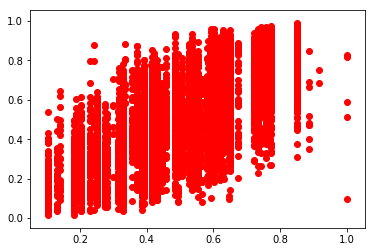

In [129]:
plt.scatter(tree_test, xg_test, color = 'red')

In [102]:
from sklearn.neighbors import KNeighborsClassifier

In [109]:
param_test8 = { 
'n_neighbors':range(200,300,20) 
} 

gsearch8 = GridSearchCV(estimator = KNeighborsClassifier(), 
param_grid = param_test8, scoring='roc_auc',n_jobs=4, iid=False, cv=5) 

gsearch8.fit(final_train.iloc[:, :35],y_train) 
gsearch8.grid_scores_, gsearch8.best_params_, gsearch8.best_score_

C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.71013, std: 0.00307, params: {'n_neighbors': 200},
  mean: 0.71064, std: 0.00298, params: {'n_neighbors': 220},
  mean: 0.71111, std: 0.00293, params: {'n_neighbors': 240},
  mean: 0.71143, std: 0.00288, params: {'n_neighbors': 260},
  mean: 0.71154, std: 0.00299, params: {'n_neighbors': 280}],
 {'n_neighbors': 280},
 0.71154151227313389)

In [111]:
param_test8 = { 
'n_neighbors':range(260,280,10) 
} 

gsearch8 = GridSearchCV(estimator = KNeighborsClassifier(), 
param_grid = param_test8, scoring='roc_auc',n_jobs=4, iid=False, cv=5) 

gsearch8.fit(final_train.iloc[:, :35],y_train) 
gsearch8.grid_scores_, gsearch8.best_params_, gsearch8.best_score_

C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.71143, std: 0.00288, params: {'n_neighbors': 260},
  mean: 0.71155, std: 0.00289, params: {'n_neighbors': 270}],
 {'n_neighbors': 270},
 0.71155037693101308)

In [103]:
knn = KNeighborsClassifier(n_neighbors = 270)
knn_train =  cross_val_predict(X=final_train.iloc[:, :35], y = y_train, estimator=knn, cv=5, method='predict_proba')[:, 1]
knn.fit(final_train.iloc[:, :35], y_train)
knn_test = knn.predict_proba(final_test.iloc[:, :35])[:, 1]

In [113]:
sweat_df_train = pd.DataFrame({'xgboost': xg_train,
     'logistic':log_train, 'knn': knn_train})

In [114]:
sweat_df_test = pd.DataFrame({'xgboost': xg_test,
     'logistic':log_test, 'knn': knn_test})

In [115]:
sweat_df_test.head()

,knn,logistic,xgboost
0,0.685185,0.806059,0.759517
1,0.825926,0.888605,0.809488
2,0.444444,0.309704,0.280654
3,0.622222,0.608443,0.419771
4,0.488889,0.348292,0.455963


In [107]:
final_train = pd.concat([final_train, sweat_df_train], axis = 1)
final_test = pd.concat([final_test, sweat_df_test], axis = 1)

In [122]:
from sklearn.svm import SVC

In [121]:
param_test4 = {
     'kernel':[ 'linear', 'poly', 'rbf']
}

gsearch4 = GridSearchCV(estimator = SVC(), 
 param_grid = param_test4, scoring='roc_auc',n_jobs=4, iid=False, cv=5)

gsearch4.fit(sweat_df_train,y_train)
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.76164, std: 0.00423, params: {'kernel': 'linear'},
  mean: 0.76108, std: 0.00416, params: {'kernel': 'poly'},
  mean: 0.75737, std: 0.00503, params: {'kernel': 'rbf'}],
 {'kernel': 'linear'},
 0.76163504057696341)

In [ ]:
param_test4 = {
     'gamma':[1, 3, 'auto'],
    'C':[1, 3, 5]
}

gsearch4 = GridSearchCV(estimator = SVC(kernel = 'linear'), 
 param_grid = param_test4, scoring='roc_auc',n_jobs=4, iid=False, cv=5)

gsearch4.fit(sweat_df_train,y_train)
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

In [125]:
cross_val_score(X = sweat_df_train, y = y_train, estimator=SVC(kernel = 'poly', C = 5, degree = 1, gamma = 1, probability = True), cv=5, scoring='roc_auc', n_jobs = 4).mean()

KeyboardInterrupt: 

In [124]:
clf = SVC(kernel = 'poly', C = 5, degree = 1, gamma = 1, probability = True)
clf.fit(sweat_df_train, y_train)
pred = clf.predict_proba(sweat_df_test)
indeces = np.array(df_test.match_id.values[::10], dtype=int)

submission = pd.DataFrame()
submission['index'] = indeces
submission['proba'] = pred[:, 1]

submission.to_csv('kras_final.csv', index=False)

In [116]:
param_test2 = {
     'C':np.arange(0.5,20,0.5)
}

gsearch2 = GridSearchCV(estimator = LogisticRegression(), 
 param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

gsearch2.fit(sweat_df_train,y_train)
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.76144, std: 0.00404, params: {'C': 0.5},
  mean: 0.76145, std: 0.00405, params: {'C': 1.0},
  mean: 0.76145, std: 0.00405, params: {'C': 1.5},
  mean: 0.76145, std: 0.00406, params: {'C': 2.0},
  mean: 0.76145, std: 0.00406, params: {'C': 2.5},
  mean: 0.76145, std: 0.00406, params: {'C': 3.0},
  mean: 0.76145, std: 0.00406, params: {'C': 3.5},
  mean: 0.76145, std: 0.00406, params: {'C': 4.0},
  mean: 0.76145, std: 0.00406, params: {'C': 4.5},
  mean: 0.76145, std: 0.00406, params: {'C': 5.0},
  mean: 0.76145, std: 0.00406, params: {'C': 5.5},
  mean: 0.76145, std: 0.00406, params: {'C': 6.0},
  mean: 0.76145, std: 0.00406, params: {'C': 6.5},
  mean: 0.76145, std: 0.00406, params: {'C': 7.0},
  mean: 0.76145, std: 0.00406, params: {'C': 7.5},
  mean: 0.76145, std: 0.00406, params: {'C': 8.0},
  mean: 0.76145, std: 0.00406, params: {'C': 8.5},
  mean: 0.76145, std: 0.00406, params: {'C': 9.0},
  mean: 0.76145, std: 0.00406, params: {'C': 9.5},
  mean: 0.76145, std: 0.00406, 

In [118]:
cross_val_score(X = sweat_df_train, y = y_train, estimator=LogisticRegression(C = 2.5), cv=5, scoring='roc_auc', n_jobs = 4).mean()

0.76145220486690302

In [120]:
log = LogisticRegression(C = 2.5)
log.fit(sweat_df_train, y_train)
pred = log.predict_proba(sweat_df_test)
indeces = np.array(df_test.match_id.values[::10], dtype=int)

submission = pd.DataFrame()
submission['index'] = indeces
submission['proba'] = pred[:, 1]

submission.to_csv('kras_final.csv', index=False)